In [66]:
import torch
import numpy as np
import torchvision
from torch.utils.data import Subset
from torch import nn
import torch.nn.functional as F
from torch import optim

# Switch between cpu and gpu depending on which is available for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
device

device(type='cuda')

In [69]:
# Application of transforms to normalize the mnist data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

cifar10_trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
cifar10_testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)


In [70]:
# Method to divide the mnist trainingset among the number of teachers to simulate unique datasets 
def private_data_loaders(trainset, teachers):
  num_part = len(trainset) // teachers
  
  priv_loaders = []
  for i in range(teachers):
    indices = list(range(i * num_part, (i + 1)*num_part)) 
    sub_pd = Subset(trainset, indices)
    temp_loader = torch.utils.data.DataLoader(sub_pd, batch_size=64, shuffle=True)
    priv_loaders.append(temp_loader)
  return priv_loaders

In [71]:
# Method for seperating the mnist test dataset into 2. The first one being the public database and the other one the private database
def test_database_seperator(testset):
  i1 = int(len(testset) * 0.9)
  ind1 = list(range(0, i1))
  ind2 = list(range(i1, len(testset)))
  
  pdb = Subset(testset, ind1)
  
  db = Subset(testset, ind2)
  
  pdb_loader = torch.utils.data.DataLoader(pdb, batch_size=64, shuffle=False)
  
  db_loader = torch.utils.data.DataLoader(db, batch_size=64, shuffle=True)
  return pdb_loader, db_loader

In [72]:
# Method for creating and training a model
def create_train_model(classifier, loader, lr = 0.12, epoch = 100):
  print("Running on ", device)
  model = classifier()
  optimizer = optim.SGD(model.parameters(), lr)
  
  criterion = nn.NLLLoss()
  
  history = {"loss": list(), "accuracy": list()}

  model.to(device)
  for i in range(epoch):
    cum_loss  = 0
    cum_perc = 0
    for imgs, labels in loader:
      imgs, labels = imgs.to(device), labels.to(device)
      optimizer.zero_grad()
      output = model.forward(imgs)
      loss = criterion(output, labels)
      loss.backward()
      cum_loss +=  loss.item()
      optimizer.step()
    for imgs, labels in loader:
      imgs, labels = imgs.to(device), labels.to(device)
      with torch.no_grad():
        ps =  torch.exp(model.forward(imgs))
      _, top_class = ps.topk(1, dim = 1)
      prob = top_class == labels.view(*top_class.shape)
      prob = prob.float()
      cum_perc += prob.mean().float()
    
    history["loss"].append(cum_loss/len(loader))
    history["accuracy"].append(cum_perc/len(loader))


    if (i == epoch -1):
      print("The loss for {0} epoch is {1}".format(i, cum_loss / len(loader)))
      print("The percentage for {0} epoch is {1}".format(i, cum_perc / len(loader)))  
  return model, history

In [73]:
# Method for running the unlabelled database through the teacher models in order to get their respective predictions for each items.

def evaluate(models, loader):
  m_labels = []
  for model in models:
    model_class = []
    for imgs, labels in loader:
      imgs = imgs.to(device)
      with torch.no_grad():
        ps =  torch.exp(model.forward(imgs))
      top_p, top_class = ps.topk(1, dim = 1)
      
      model_class.append(np.array(top_class.cpu()).T)
    m_label = np.hstack(model_class)
    m_labels.append(m_label)
  return m_labels

In [74]:
# Method for creating and training the teacher models
def train_teacher_models(loaders, lr = 0.12, epoch = 10):
  teacher_models = []
  for loader in loaders:
    model, _ = create_train_model(classifier, loader, lr, epoch)
    teacher_models.append(model)
  return teacher_models


In [75]:
#Method for applying Global differential privacy to the labels predicted by the teacher models and to perform PATE analysis.
def return_new_indices(preds, epsilon):
  preds = preds.T
  ind = []
  beta = 1 / epsilon
  for pred in preds:
    label_count = np.bincount(pred, minlength = 10)
    for i in range(len(label_count)):
      label_count[i] += np.random.laplace(0, beta, 1)
    new_labels = np.argmax(label_count)
    ind.append(new_labels)

  ind = np.array(ind)
  return ind

def pate_analysis(pred, ind, epsilon):
  dde, die = pate.perform_analysis(teacher_preds = pred, indices = ind, noise_eps = epsilon, delta = 1e-5 )
  print("Data dependent epsilon ", dde)
  print("Data Independent epsilon ", die)

In [76]:
#Method to create a new dataloader with the new target labels and the public database
def join_label_image(dataloader, ind):
  img_list = []
  for img, _ in dataloader:
    img_list.append(img)

  images = np.vstack(img_list)

  model_zip = list(zip(images, ind))
  modelloader = torch.utils.data.DataLoader(model_zip, shuffle=True, batch_size=64)
  return modelloader

In [77]:
#Method o analyze the private database with the trained model
def analyze_privatedata(model, loader):
  print("Running on ", device)
  model.to(device)
  cum_perc = 0
  for imgs, labels in loader:
    imgs, labels = imgs.to(device), labels.to(device)
    with torch.no_grad():
      ps =  torch.exp(model.forward(imgs))
    _, top_class = ps.topk(1, dim = 1)
    prob = top_class == labels.view(*top_class.shape)
    prob = prob.float()
    cum_perc += prob.mean().float()
  print("The accuracy of the differentially private model on the private dataset is {0}%".format((cum_perc / len(loader)) * 100))  


In [78]:
#Classifier for creating the models
class classifier(nn.Module):
  def __init__(self):
    super().__init__() 
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 10)
    
    self.dropout = nn.Dropout(p = 0.2)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = F.log_softmax(self.fc5(x), dim = 1)   
    return x

In [43]:
#Classifier for creating the models
class classifier(nn.Module):
  def __init__(self):
    super().__init__() 
    self.fc1 = nn.Linear(3072, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 10)
    
    self.dropout = nn.Dropout(p = 0.2)
    
  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = F.log_softmax(self.fc5(x), dim = 1)   
    return x

In [102]:
teachers = 100
epsilon = 0.7

In [103]:
pdb, db = test_database_seperator(mnist_testset)
teachers_loaders = private_data_loaders(mnist_trainset, teachers)

In [104]:
teacher_models = train_teacher_models(teachers_loaders, lr = 0.12, epoch = 40)

Running on  cuda
The loss for 39 epoch is 0.9288483113050461
The percentage for 39 epoch is 0.8114582896232605
Running on  cuda
The loss for 39 epoch is 0.45420289039611816
The percentage for 39 epoch is 0.878125011920929
Running on  cuda
The loss for 39 epoch is 0.4472201958298683
The percentage for 39 epoch is 0.8135417103767395
Running on  cuda
The loss for 39 epoch is 0.3118019670248032
The percentage for 39 epoch is 0.8635417222976685
Running on  cuda
The loss for 39 epoch is 0.7474961340427398
The percentage for 39 epoch is 0.784375011920929
Running on  cuda
The loss for 39 epoch is 0.5188454151153564
The percentage for 39 epoch is 0.7041666507720947
Running on  cuda
The loss for 39 epoch is 0.6413392782211303
The percentage for 39 epoch is 0.7020833492279053
Running on  cuda
The loss for 39 epoch is 0.5313070029020309
The percentage for 39 epoch is 0.8348957896232605
Running on  cuda
The loss for 39 epoch is 1.0728334486484528
The percentage for 39 epoch is 0.6963541507720947
Ru

In [105]:
teachers_pred = np.array(evaluate(teacher_models, pdb))
teachers_pred = teachers_pred.reshape(teachers, -1)

In [106]:
indices = return_new_indices(teachers_pred, epsilon)

In [107]:
labelledloader = join_label_image(pdb, indices)
dp_model, dp_history = create_train_model(classifier, labelledloader, lr = 0.06, epoch = 30)

Running on  cuda
The loss for 29 epoch is 0.11098006428450558
The percentage for 29 epoch is 0.962367057800293


In [108]:
no_dp_model, no_dp_history = create_train_model(classifier, pdb, lr = 0.06, epoch = 30)

Running on  cuda
The loss for 29 epoch is 0.0994957778289095
The percentage for 29 epoch is 0.968195915222168


In [109]:
analyze_privatedata(dp_model, db)

Running on  cuda
The accuracy of the differentially private model on the private dataset is 85.5078125%


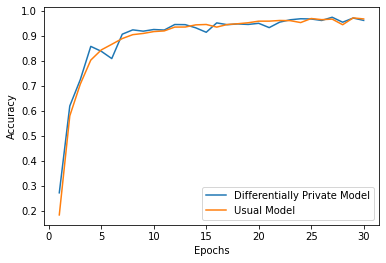

In [110]:
import matplotlib.pyplot as plt
  
# create data
x = np.linspace(1, 30, 30)
  
# plot lines
fig = plt.figure()
plt.plot(x, [a.cpu() for a in dp_history["accuracy"]], label = "Differentially Private Model")
plt.plot(x, [a.cpu() for a in no_dp_history["accuracy"]], label = "Usual Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

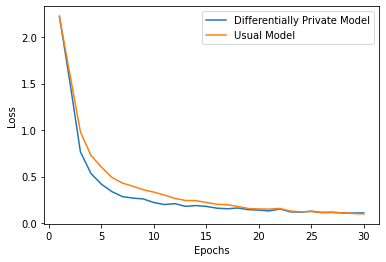

In [111]:
import matplotlib.pyplot as plt
  
# create data
x = np.linspace(1, 30, 30)
  
# plot lines
fig = plt.figure()
plt.plot(x, dp_history["loss"], label = "Differentially Private Model")
plt.plot(x, no_dp_history["loss"], label = "Usual Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()